In [2]:
import time
start=time.time() 
import pandas as pd
import numpy as np
import os,re 
from sklearn.externals import joblib
import logging
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %I:%M:%S %p')
os.getcwd()
os.chdir('C:/Users/tjoseph/Documents/text mining/lda/googleplaystore_user_reviews.csv')

In [3]:
df=pd.read_csv('googleplaystore_user_reviews.csv')

In [4]:
df = df.dropna(subset=['Translated_Review'])


In [5]:
# Convert to list
def clean_text(data):
    data = df.Translated_Review.values.tolist()
    # Remove Emails
    data = [re.sub(r'\S*@\S*\s?', '', sent) for sent in data]
    # Remove new line characters
    data = [re.sub(r'\s+', ' ', sent) for sent in data]
    # Remove distracting single quotes
    data = [re.sub(r"\'", "", sent) for sent in data]
    return data


In [6]:
data = df.Translated_Review.values.tolist()
    # Remove Emails
data = [re.sub(r'\S*@\S*\s?', '', sent) for sent in data]
    # Remove new line characters
data = [re.sub(r'\s+', ' ', sent) for sent in data]
    # Remove distracting single quotes
data = [re.sub(r"\'", "", sent) for sent in data]


In [7]:
import gensim
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data_words = list(sent_to_words(data))

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [8]:
import spacy
import en_core_web_sm
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en import LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES
lemmatizer=Lemmatizer(LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES)
nlp=spacy.load('en_core_web_sm',disable=['parser','ner'])

In [9]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']): #'NOUN', 'ADJ', 'VERB', 'ADV'
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

In [10]:
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'VERB'])

In [11]:
data_lemmatized[:2]

['eat food s be cook food case food help lot shelf life',
 'help eat exercise basis']

###  Document-Word matrix
####  can create one using CountVectorizer.

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer=CountVectorizer(analyzer='word',\
                           stop_words='english',\
                           lowercase=True,min_df=10,\
                           token_pattern='[a-zA-Z0-9]{3,}',\
                           max_features=50000) 

In [13]:
vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=50000, min_df=10,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='[a-zA-Z0-9]{3,}',
        tokenizer=None, vocabulary=None)

In [14]:
data_vectorized=vectorizer.fit_transform(data_lemmatized)

In [15]:
data_vectorized

<37427x2366 sparse matrix of type '<class 'numpy.int64'>'
	with 270271 stored elements in Compressed Sparse Row format>

In [16]:
data_vectorized.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

#### LDA model with sklearn


In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
lda_model=LatentDirichletAllocation(n_components=20,\
                                   learning_method='online',\
                                   max_iter=10,\
                                   random_state=100,\
                                   batch_size=128,\
                                   evaluate_every=-1,\
                                   n_jobs=-1)
# n_components::::no of topics
# batch_size::::n docs in each learning iter

In [ ]:
lda_output=lda_model.fit_transform(data_vectorized)

In [ ]:
print(lda_model)

In [ ]:
lda_output.shape

In [17]:
data_vectorized.toarray().shape

(37427, 2366)

###  Diagnose model performance with perplexity and log-likelihood
#### A model with higher log-likelihood and lower perplexity (exp(-1. * log-likelihood per word)) is considered to be good.

In [ ]:
# Log Likelyhood: Higher the better

print('Log Likelyhood of LDA model is {0}'.format(lda_model.score(data_vectorized)))

In [ ]:
## Perplexity: Lower the better.erplexity = exp(-1. * log-likelihood per word)
print('Perplixity of LDA model is {0}'.format(lda_model.perplexity(data_vectorized)))

In [ ]:
lda_model.get_params()

##  Use GridSearch to determine the best LDA model


##### The most important tuning parameter for LDA models is n_components (number of topics).

##### In addition, we are going to search learning_decay (which controls the learning rate) as well.

In [18]:
#define search params
search_params={'n_components':list(np.arange(10,35,5)),'learning_decay':[.5, .7, .9]}

In [19]:
search_params

{'n_components': [10, 15, 20, 25, 30], 'learning_decay': [0.5, 0.7, 0.9]}

In [20]:
from sklearn.decomposition import LatentDirichletAllocation
lda=LatentDirichletAllocation(max_iter=5,learning_method='online',learning_offset=50,random_state=0)

In [21]:
#Initialize Grid Search Class
from sklearn.model_selection import GridSearchCV
#model=GridSearchCV(lda,param_grid=search_params)


In [22]:
#type(model)

In [ ]:
# Do the grid search (saved as pickle)
model.fit(data_vectorized)

GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_topics': [10, 15, 20, 25, 30], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [ ]:
model=GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_topics': [10, 15, 20, 25, 30], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=False, return_train_score='warn',
       scoring=None, verbose=0)
%time joblib.dump(model.fit(data_vectorized),'trained_refit_false.pkl')

In [23]:
model=joblib.load('trained_refit_false.pkl')

In [24]:
best_lda_model=joblib.load('lda_best_estimator.pkl')  

In [25]:
#Best LDA Model
best_lda_model

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.9,
             learning_method='online', learning_offset=50,
             max_doc_update_iter=100, max_iter=5, mean_change_tol=0.001,
             n_components=10, n_jobs=1, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [ ]:
model.best_params_

In [ ]:
#Best LDA Model

best_lda_model=model.best_estimator_
best_lda_model

In [ ]:
#Model Parameters
print("Best Model's Params: ",model.best_params_)

In [26]:
#Log Likelihood Score
%time print("Best Log Likelihood Score: ",model.best_score_)

Best Log Likelihood Score:  -729997.1707369515
Wall time: 2.88 ms


In [27]:
#Perplexity
%time print("Model Perplexity:",best_lda_model.perplexity(data_vectorized))

Model Perplexity: 773.0967160068755
Wall time: 3.6 s


## Dominant  Topic

In [28]:
#Create a document topic matrix
lda_output=best_lda_model.transform(data_vectorized)

In [29]:
lda_output

array([[0.01      , 0.0100001 , 0.01000141, ..., 0.01      , 0.01000344,
        0.82559366],
       [0.02      , 0.02000122, 0.02001677, ..., 0.02      , 0.02000005,
        0.61520725],
       [0.51852693, 0.025     , 0.28145664, ..., 0.02500169, 0.02500004,
        0.0250007 ],
       ...,
       [0.16122613, 0.19533602, 0.00769249, ..., 0.00769572, 0.00769242,
        0.44990748],
       [0.26724989, 0.00909612, 0.10367514, ..., 0.00909271, 0.0090914 ,
        0.13773453],
       [0.01666827, 0.01666736, 0.01666672, ..., 0.01666716, 0.01666691,
        0.84999194]])

In [30]:
['Topic' + str(i) for i in range(best_lda_model.n_components)]

['Topic0',
 'Topic1',
 'Topic2',
 'Topic3',
 'Topic4',
 'Topic5',
 'Topic6',
 'Topic7',
 'Topic8',
 'Topic9']

In [31]:
#column names ****sample above****
topic_names=['Topic' + str(i) for i in range(best_lda_model.n_components)]

In [32]:
#index names
doc_names=['Doc'+str(i) for i in range(len(data))]

In [33]:
#Make Pandas DF
df_document_topic=pd.DataFrame(np.round(lda_output,2),columns=topic_names,index=doc_names)

In [34]:
df_document_topic.head()

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9
Doc0,0.01,0.01,0.01,0.01,0.01,0.09,0.01,0.01,0.01,0.83
Doc1,0.02,0.02,0.02,0.22,0.02,0.02,0.02,0.02,0.02,0.62
Doc2,0.52,0.03,0.28,0.03,0.03,0.03,0.03,0.03,0.03,0.03
Doc3,0.05,0.05,0.05,0.05,0.05,0.55,0.05,0.05,0.05,0.05
Doc4,0.05,0.05,0.55,0.05,0.05,0.05,0.05,0.05,0.05,0.05


In [35]:
#Get dominant topic for each document
dominant_topic=np.argmax(df_document_topic.values,axis=1)

In [36]:
dominant_topic

array([9, 9, 0, ..., 9, 0, 9], dtype=int64)

In [37]:
df_document_topic['dominant_topic']=dominant_topic

In [38]:
df_document_topic.head()

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0.01,0.01,0.01,0.01,0.01,0.09,0.01,0.01,0.01,0.83,9
Doc1,0.02,0.02,0.02,0.22,0.02,0.02,0.02,0.02,0.02,0.62,9
Doc2,0.52,0.03,0.28,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0
Doc3,0.05,0.05,0.05,0.05,0.05,0.55,0.05,0.05,0.05,0.05,5
Doc4,0.05,0.05,0.55,0.05,0.05,0.05,0.05,0.05,0.05,0.05,2


In [39]:
#Styling
def color_green(val):
    color='green' if val>0.1 else 'white'
    return 'color:{col}'.format(col=color)
def make_bold(val):
    weight=700 if val>0.1 else 400
    return 'font-weight:{weight}'.format(weight=weight)

In [40]:
#Apply Style-Top15 docs
df_document_topics=df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)

In [41]:
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0.01,0.01,0.01,0.01,0.01,0.09,0.01,0.01,0.01,0.83,9
Doc1,0.02,0.02,0.02,0.22,0.02,0.02,0.02,0.02,0.02,0.62,9
Doc2,0.52,0.03,0.28,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0
Doc3,0.05,0.05,0.05,0.05,0.05,0.55,0.05,0.05,0.05,0.05,5
Doc4,0.05,0.05,0.55,0.05,0.05,0.05,0.05,0.05,0.05,0.05,2
Doc5,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0
Doc6,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.7,9
Doc7,0.03,0.03,0.03,0.03,0.03,0.29,0.03,0.03,0.03,0.51,9
Doc8,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0
Doc9,0.9,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0


In [42]:
#Topic-Keyword Matrix
df_topic_keywords=pd.DataFrame(best_lda_model.components_)

In [43]:
#Assign columns and index

df_topic_keywords.columns=vectorizer.get_feature_names()
df_topic_keywords.index=topic_names

In [44]:
df_topic_keywords.head()

,aap,abandon,abc,ability,abuse,accept,access,accessory,accident,accommodation,...,yoga,youtube,yrs,zen,zillow,zip,zombie,zone,zoom,zoosk
Topic0,0.102902,0.105288,0.139290,6.879378,0.116439,120.003465,0.467424,0.114476,0.110602,0.102795,...,0.102581,0.402407,0.298497,0.105609,0.102074,0.162574,0.224053,19.963270,0.517574,0.105379
Topic1,0.102346,0.147890,0.102092,0.216200,15.313387,0.106278,565.811477,0.102272,0.102325,9.975534,...,0.106145,0.120082,32.432169,0.111073,0.125966,0.103696,0.102882,0.111379,0.438600,0.378830
Topic2,0.102024,0.102702,0.102411,51.608134,0.101973,0.114240,0.103038,0.102017,0.680287,0.115182,...,55.596225,0.106164,0.113903,0.118559,0.102070,0.102519,0.102043,0.120297,0.104362,0.102929
Topic3,0.102355,0.103021,0.102126,0.104877,0.102667,2.377560,0.143680,0.108807,9.846610,0.103926,...,0.102701,99.802611,0.105158,0.109692,0.102493,0.133721,0.122529,0.102834,0.103322,5.364994
Topic4,0.102339,0.107925,6.919324,16.393093,0.103285,0.120705,0.107285,0.102248,0.104811,0.105865,...,0.105417,0.103405,0.104905,1.606869,0.124376,0.101678,0.104293,0.120816,0.320753,5.047961


### Get the top15 keywords each topic
## Topic word distribution. components_[i, j] represents word j in topic i.

In [45]:
#Show top n keywords for each topic
def show_topics(vectorizer=vectorizer,lda_model=best_lda_model,n_words=20):
    keywords=np.array(vectorizer.get_feature_names())
    topic_keywords=[]
    for topic_weights in lda_model.components_:
        top_keyword_locs=(-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords
topic_keywords=show_topics(vectorizer=vectorizer,lda_model=best_lda_model,n_words=15)    

In [46]:
#Topic -Keywords DataFrame
df_topic_keywords=pd.DataFrame(topic_keywords)
df_topic_keywords.columns=['Word' + str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index=['Topic'+str(i) for i in range(df_topic_keywords.shape[0])]

In [47]:
df_topic_keywords.head()

,Word0,Word1,Word2,Word3,Word4,Word5,Word6,Word7,Word8,Word9,Word10,Word11,Word12,Word13,Word14
Topic0,update,work,try,fix,pay,star,want,problem,use,app,review,crash,say,issue,version
Topic1,time,need,download,book,waste,access,ask,mean,internet,world,ticket,question,say,recommend,good
Topic2,way,thing,learn,wish,kid,image,help,set,sound,fun,write,record,recipe,share,video
Topic3,play,time,make,card,buy,watch,video,load,tell,say,money,spend,happen,enjoy,thing
Topic4,love,news,notification,guy,run,use,word,color,deal,article,work,family,story,music,support


In [48]:
Topics = ["Update Version/Fix Crash Problem","Download/Internet Access","Learn and Share","Card Payment","Notification/Support", 
          "Account Problem", "Device/Design/Password", "Language/Recommend/Screen Size", "Graphic/ Game Design/ Level and Coin", "Photo/Search"]
df_topic_keywords["Topics"]=Topics
df_topic_keywords

,Word0,Word1,Word2,Word3,Word4,Word5,Word6,Word7,Word8,Word9,Word10,Word11,Word12,Word13,Word14,Topics
Topic0,update,work,try,fix,pay,star,want,problem,use,app,review,crash,say,issue,version,Update Version/Fix Crash Problem
Topic1,time,need,download,book,waste,access,ask,mean,internet,world,ticket,question,say,recommend,good,Download/Internet Access
Topic2,way,thing,learn,wish,kid,image,help,set,sound,fun,write,record,recipe,share,video,Learn and Share
Topic3,play,time,make,card,buy,watch,video,load,tell,say,money,spend,happen,enjoy,thing,Card Payment
Topic4,love,news,notification,guy,run,use,word,color,deal,article,work,family,story,music,support,Notification/Support
Topic5,phone,make,use,day,app,come,thank,year,minute,account,save,money,work,email,version,Account Problem
Topic6,screen,device,check,price,hate,issue,feature,force,change,design,improve,enter,camera,lock,password,Device/Design/Password
Topic7,add,people,option,feel,app,want,recommend,language,wish,read,quality,file,widget,suck,watch,Language/Recommend/Screen Size
Topic8,game,play,level,fun,player,lot,character,star,start,win,lose,graphic,need,think,coin,Graphic/ Game Design/ Level and Coin
Topic9,app,help,look,picture,think,photo,month,search,lot,need,food,thing,add,know,thank,Photo/Search


### Predict topics using LDA model

##### Text to predict should follow through same routine  of transformations before predicting the topic

#### Order of transofrmation in our case

##### sent_to_words()-------->Stemming()------>vectorizer.transform()------>best_lda_model.transform()

In [49]:
nlp=spacy.load('en_core_web_sm',disable=['parser','ner'])

In [50]:
nlp

In [51]:

# Define function to predict topic for a given text document.
 
def predict_topic(text, nlp=nlp):
    global sent_to_words
    global lemmatization
# Step 1: Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))
# Step 2: Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
# Step 3: Vectorize transform
    mytext_4 = vectorizer.transform(mytext_3)
# Step 4: LDA Transform
    topic_probability_scores = best_lda_model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), 1:14].values.tolist()
    
    # Step 5: Infer Topic
    infer_topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), -1]
    
    #topic_guess = df_topic_keywords.iloc[np.argmax(topic_probability_scores), Topics]
    return infer_topic, topic, topic_probability_scores
# Predict the topic
mytext = ["Very Useful in diabetes age 30. I need control sugar. thanks Good deal"]
infer_topic, topic, prob_scores = predict_topic(text = mytext)
print(topic)
print(infer_topic)

['help', 'look', 'picture', 'think', 'photo', 'month', 'search', 'lot', 'need', 'food', 'thing', 'add', 'know']
Photo/Search


# Predict topics of our reviews in original dataset
def apply_predict_topic(text):
    text=[text]
    infer_topic,topic,preob_scores=predict_topic(text=text)
    return(infer_topic)

%timeit df['Topic_key_word']=df['Translated_Review'].apply(lambda x:apply_predict_topic(x))

In [52]:
df=pd.read_pickle('LDA.pkl')

In [53]:
df.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity,Topic_key_word
0,10 Best Foods for You,Photo/Search,Positive,1.00,0.533333,Photo/Search
1,10 Best Foods for You,Photo/Search,Positive,0.25,0.288462,Photo/Search
3,10 Best Foods for You,Update Version/Fix Crash Problem,Positive,0.40,0.875000,Update Version/Fix Crash Problem
4,10 Best Foods for You,Account Problem,Positive,1.00,0.300000,Update Version/Fix Crash Problem
5,10 Best Foods for You,Learn and Share,Positive,1.00,0.300000,Learn and Share


In [54]:
df.groupby('Topic_key_word').nunique()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity,Topic_key_word
Topic_key_word,,,,,,
Account Problem,614,1,3,803,651,1
Device/Design/Password,653,1,3,750,612,1
Download/Internet Access,714,1,3,787,628,1
Graphic/ Game Design/ Level and Coin,399,1,3,1955,1482,1
Language/Recommend/Screen Size,538,1,3,544,454,1
Learn and Share,570,1,3,619,569,1
Notification/Support,586,1,3,550,422,1
Photo/Search,685,1,3,1189,966,1
Update Version/Fix Crash Problem,827,2,3,2782,2220,1


##### CLuster documents that share similiar topics and plot

In [55]:
#Construct the k-means clusters
%time from sklearn.cluster import KMeans

clusters=KMeans(n_clusters=15,random_state=100).fit_predict(lda_output)

Wall time: 957 ms


In [56]:
#Build Singular Value Decomposition(SVD) model 
from sklearn.decomposition import TruncatedSVD
svd_model=TruncatedSVD(n_components=2)
lda_output_svd=svd_model.fit_transform(lda_output)


In [57]:
# X and Y axes of the plot using SVD decomposition

x=lda_output_svd[:,0]
y=lda_output_svd[:,1]
    

In [58]:
#Weights for the 15 columns of lda_output,for each component

print("Component's weights: \n ",np.round(svd_model.components_,2))

Component's weights: 
  [[ 0.57  0.22  0.19  0.27  0.22  0.37  0.24  0.21  0.36  0.32]
 [-0.69  0.05  0.07  0.13  0.09  0.07  0.    0.06  0.69  0.09]]


In [59]:
# Percentage of total infirmation in 'lda_output' explained by the two components
print('Perc of variance explained: \n',np.round(svd_model.explained_variance_ratio_,2))

Perc of variance explained: 
 [0.02 0.2 ]


In [60]:
# Plot the document along the two SVD decomposed componets

Text(0.5,1,'Segregation of Topic Clusters')

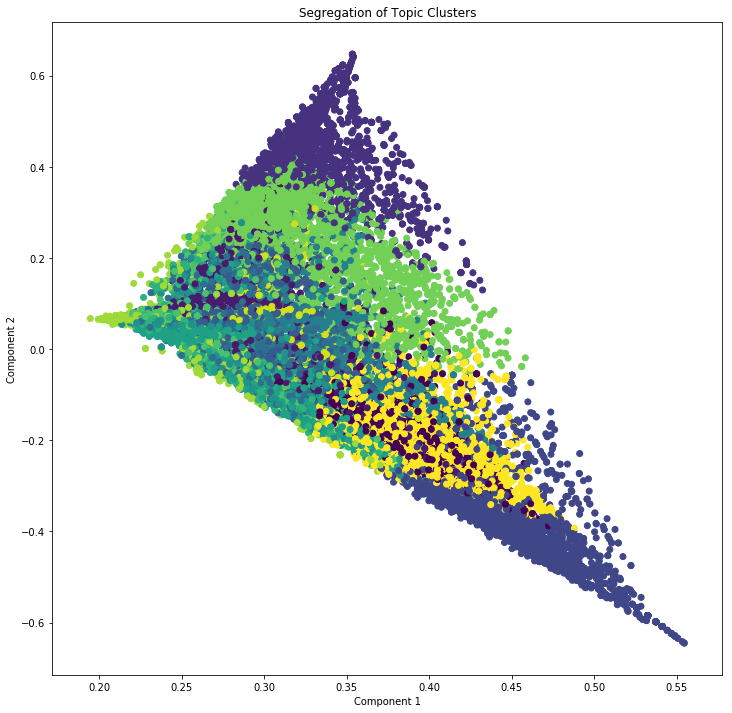

In [61]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(12,12))
plt.scatter(x,y,c=clusters)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Segregation of Topic Clusters')


In [77]:
# Get similiar documents for given piece of text
from sklearn.metrics.pairwise import euclidean_distances
nlp=spacy.load('en_core_web_sm',disable=['parser','ner'])
def similar_documents(text, doc_topic_probs, documents = data, nlp=nlp, top_n=5, verbose=False):
    infer_topic, topic, x  = predict_topic(text)
    dists = euclidean_distances(x.reshape(1, -1), doc_topic_probs)[0]
    doc_ids = np.argsort(dists)[:top_n]
    if verbose:        
        print("Topic KeyWords: ", topic)
        print("Topic Prob Scores of text: ", np.round(x, 1))
        print("Most Similar Doc's Probs:  ", np.round(doc_topic_probs[doc_ids], 1))
    return doc_ids, np.take(documents, doc_ids)    
        


In [78]:
mytext = ["I think they are really helpful"]
doc_ids, docs = similar_documents(text=mytext, doc_topic_probs=lda_output, documents = data, top_n=1, verbose=True)
print('\n', docs[0][:500])
print()

Topic KeyWords:  ['make', 'use', 'day', 'app', 'come', 'thank', 'year', 'minute', 'account', 'save', 'money', 'work', 'email']
Topic Prob Scores of text:  [[0.  0.  0.  0.  0.  0.7 0.  0.  0.  0. ]]
Most Similar Doc's Probs:   [[0.  0.  0.  0.  0.  0.7 0.  0.  0.  0. ]]

 Better brainless runners, actually makes think



In [ ]:
end=time.time()
print('Execution time is {0} minutes'.format(np.round((end-start)/60),2))